# Figure 5: Integrating GWAS summary statistic data with scRNA data

In [ ]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(dpi_save = 300, frameon = False)

FIGSIZE = (10,8)
rcParams["figure.figsize"] = FIGSIZE

In [ ]:
data = sc.read_h5ad('data.h5ad')

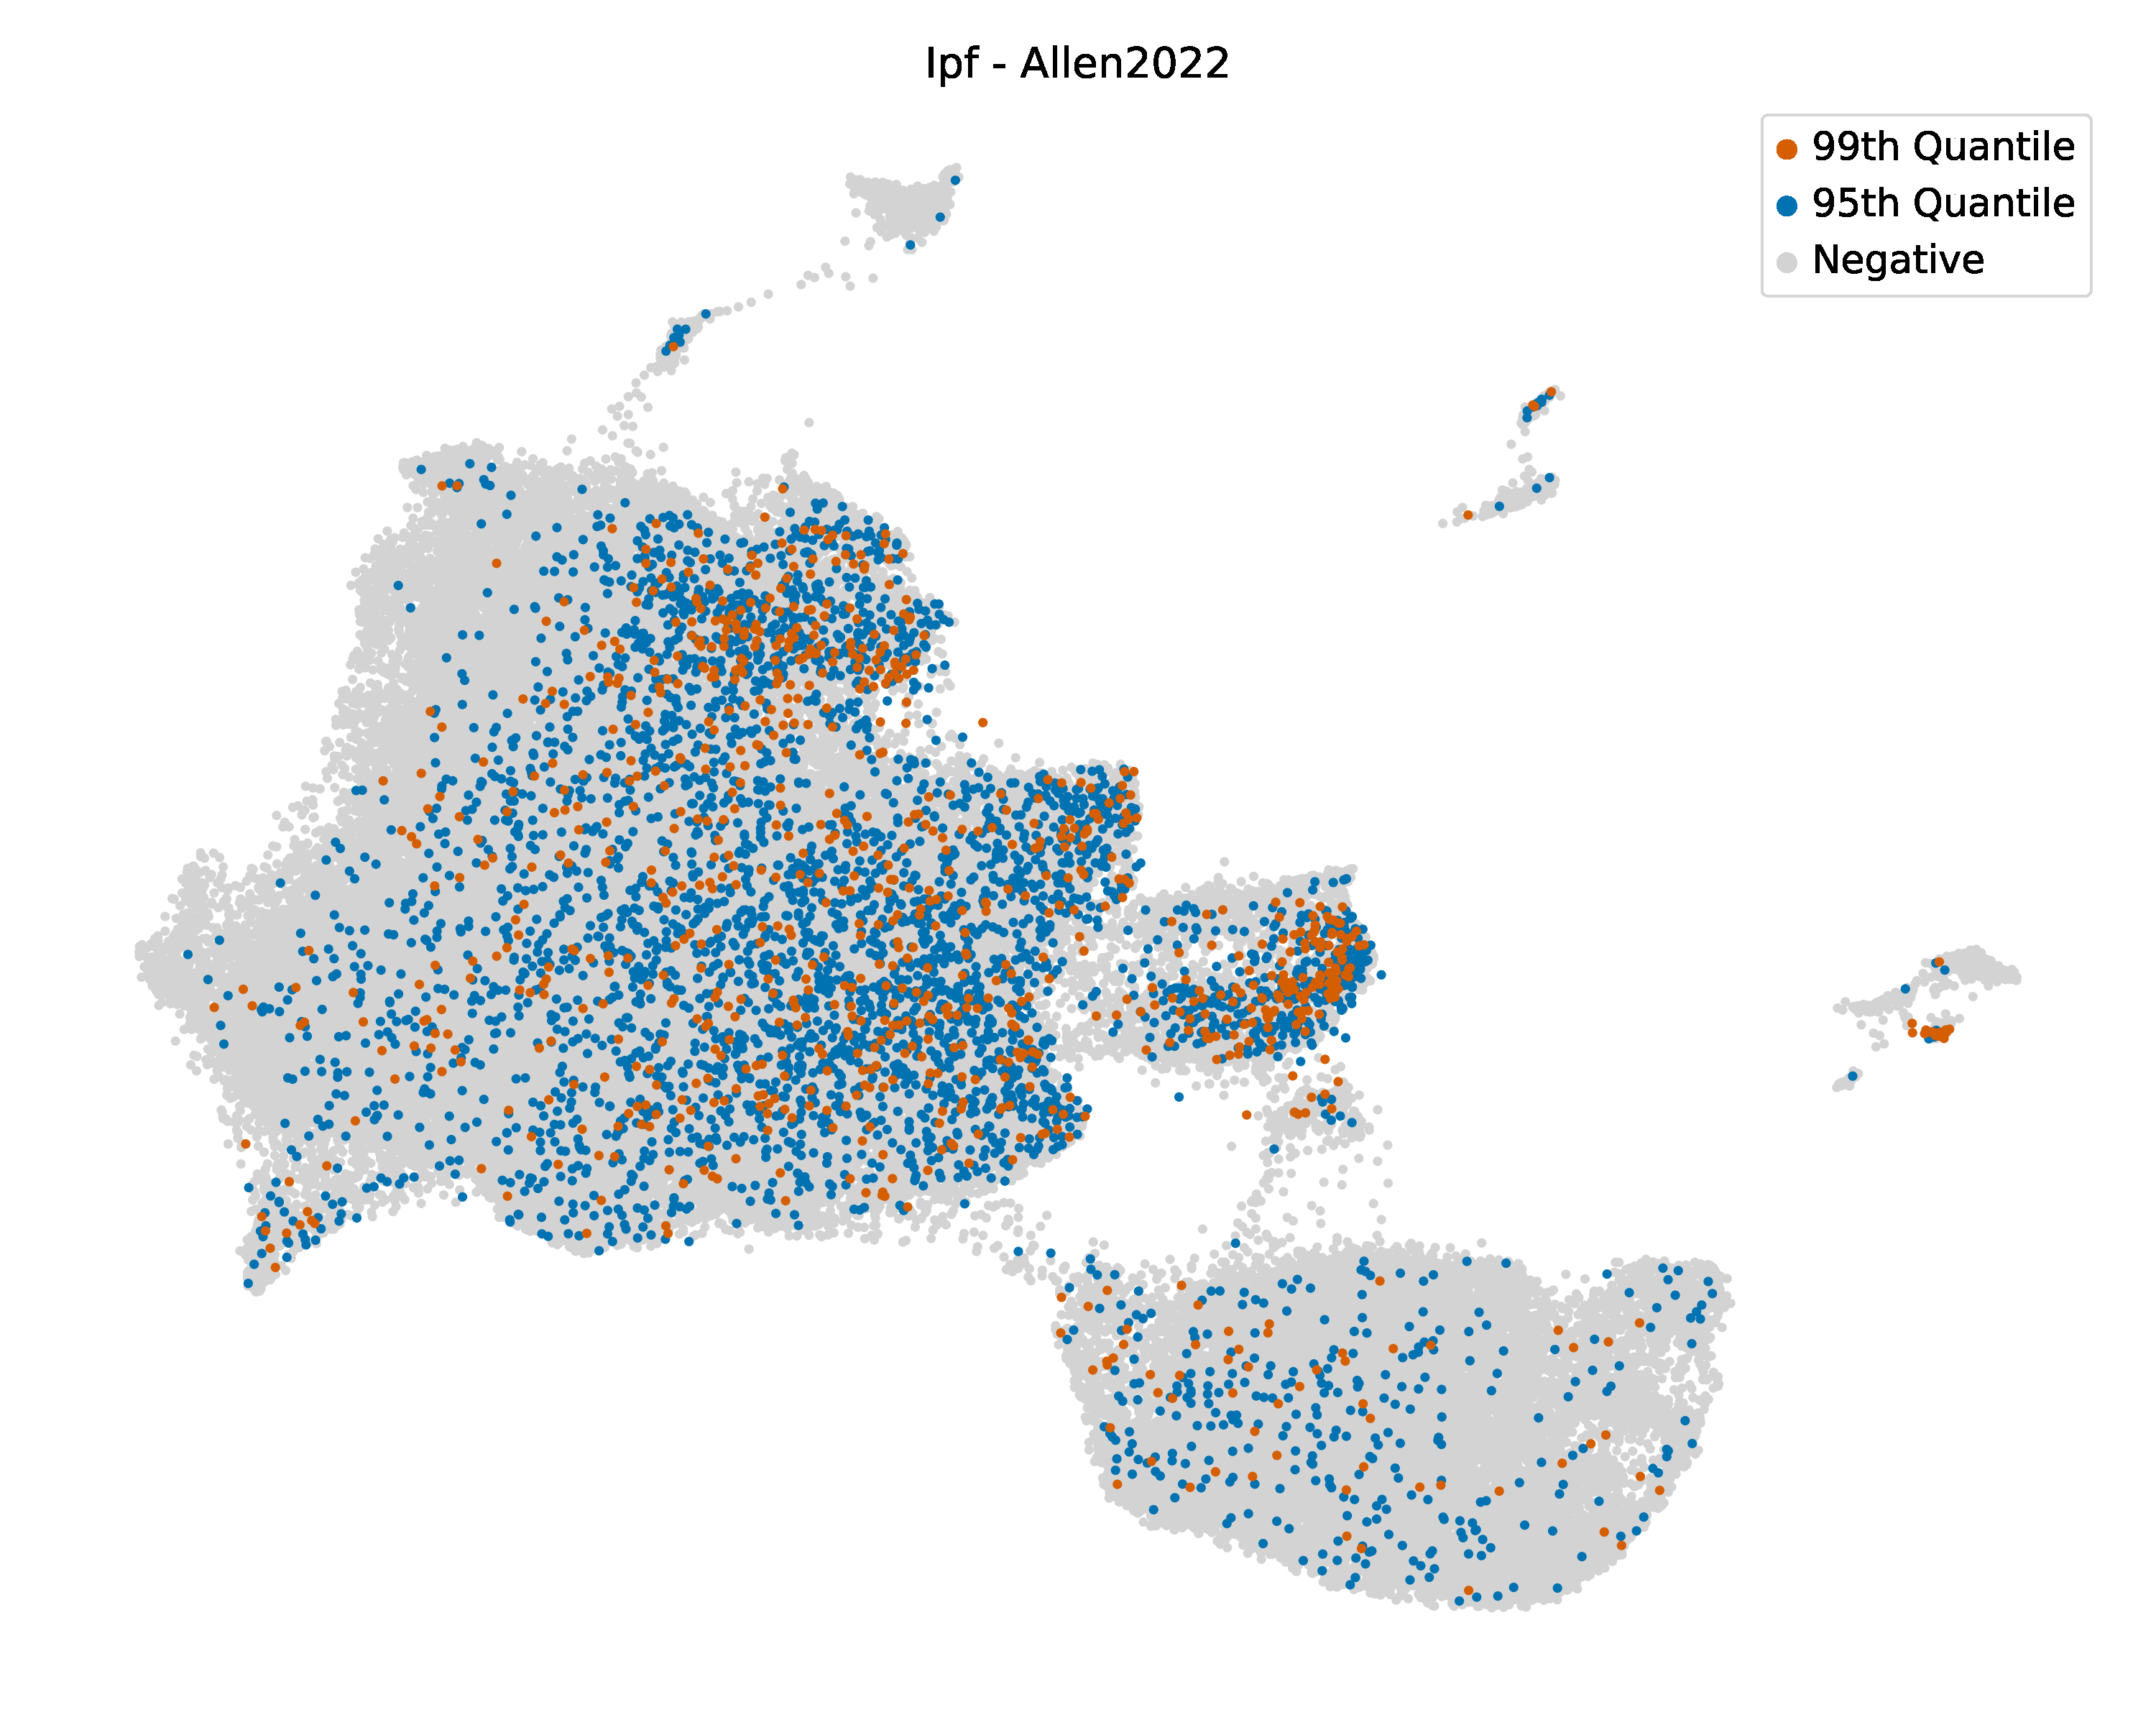

In [ ]:
trait = 'ipf_allen2022'

dict_score = {
    trait: pd.read_csv(f"output/scdrs_bal/20250312_bal_ipf/{trait}.full_score.gz", sep="\t", index_col=0)
}

adata.obs[trait] = dict_score[trait]["norm_score"]

# Create a new column for positive/negative cells based on the threshold
threshold_95 = adata.obs[trait].quantile(0.95)
threshold_99 = adata.obs[trait].quantile(0.99)
adata.obs[f'{trait}_binary'] = adata.obs[trait].apply(
    lambda x: 'Top1' if x > threshold_99 else ('Top5' if x > threshold_95 else 'Negative')
)

# Define the color palette for positive and negative cells
palette = {'Top1': '#d55e00', 'Top5': '#0072b2', 'Negative': 'lightgray'}

# Sort the data so that Top1 points are plotted on top, then Top5, then Negative
adata_sorted = adata[adata.obs[f'{trait}_binary'] == 'Negative'].concatenate(
    adata[adata.obs[f'{trait}_binary'] == 'Top5']
).concatenate(
    adata[adata.obs[f'{trait}_binary'] == 'Top1']
)

# Plot the UMAP with the binary classification
sc.pl.umap(adata_sorted, color=f'{trait}_binary', palette=palette, save=False, frameon=False, size=40, title=f'{trait.replace("_", " - ").title()}')

# Modify the legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['99th Quantile' if label == 'Top1' else '95th Quantile' if label == 'Top5' else 'Negative' for label in labels]
order = [new_labels.index('99th Quantile'), new_labels.index('95th Quantile'), new_labels.index('Negative')]
plt.legend([handles[idx] for idx in order], [new_labels[idx] for idx in order], loc='best')

plt.tight_layout()


## Subset to MLMs

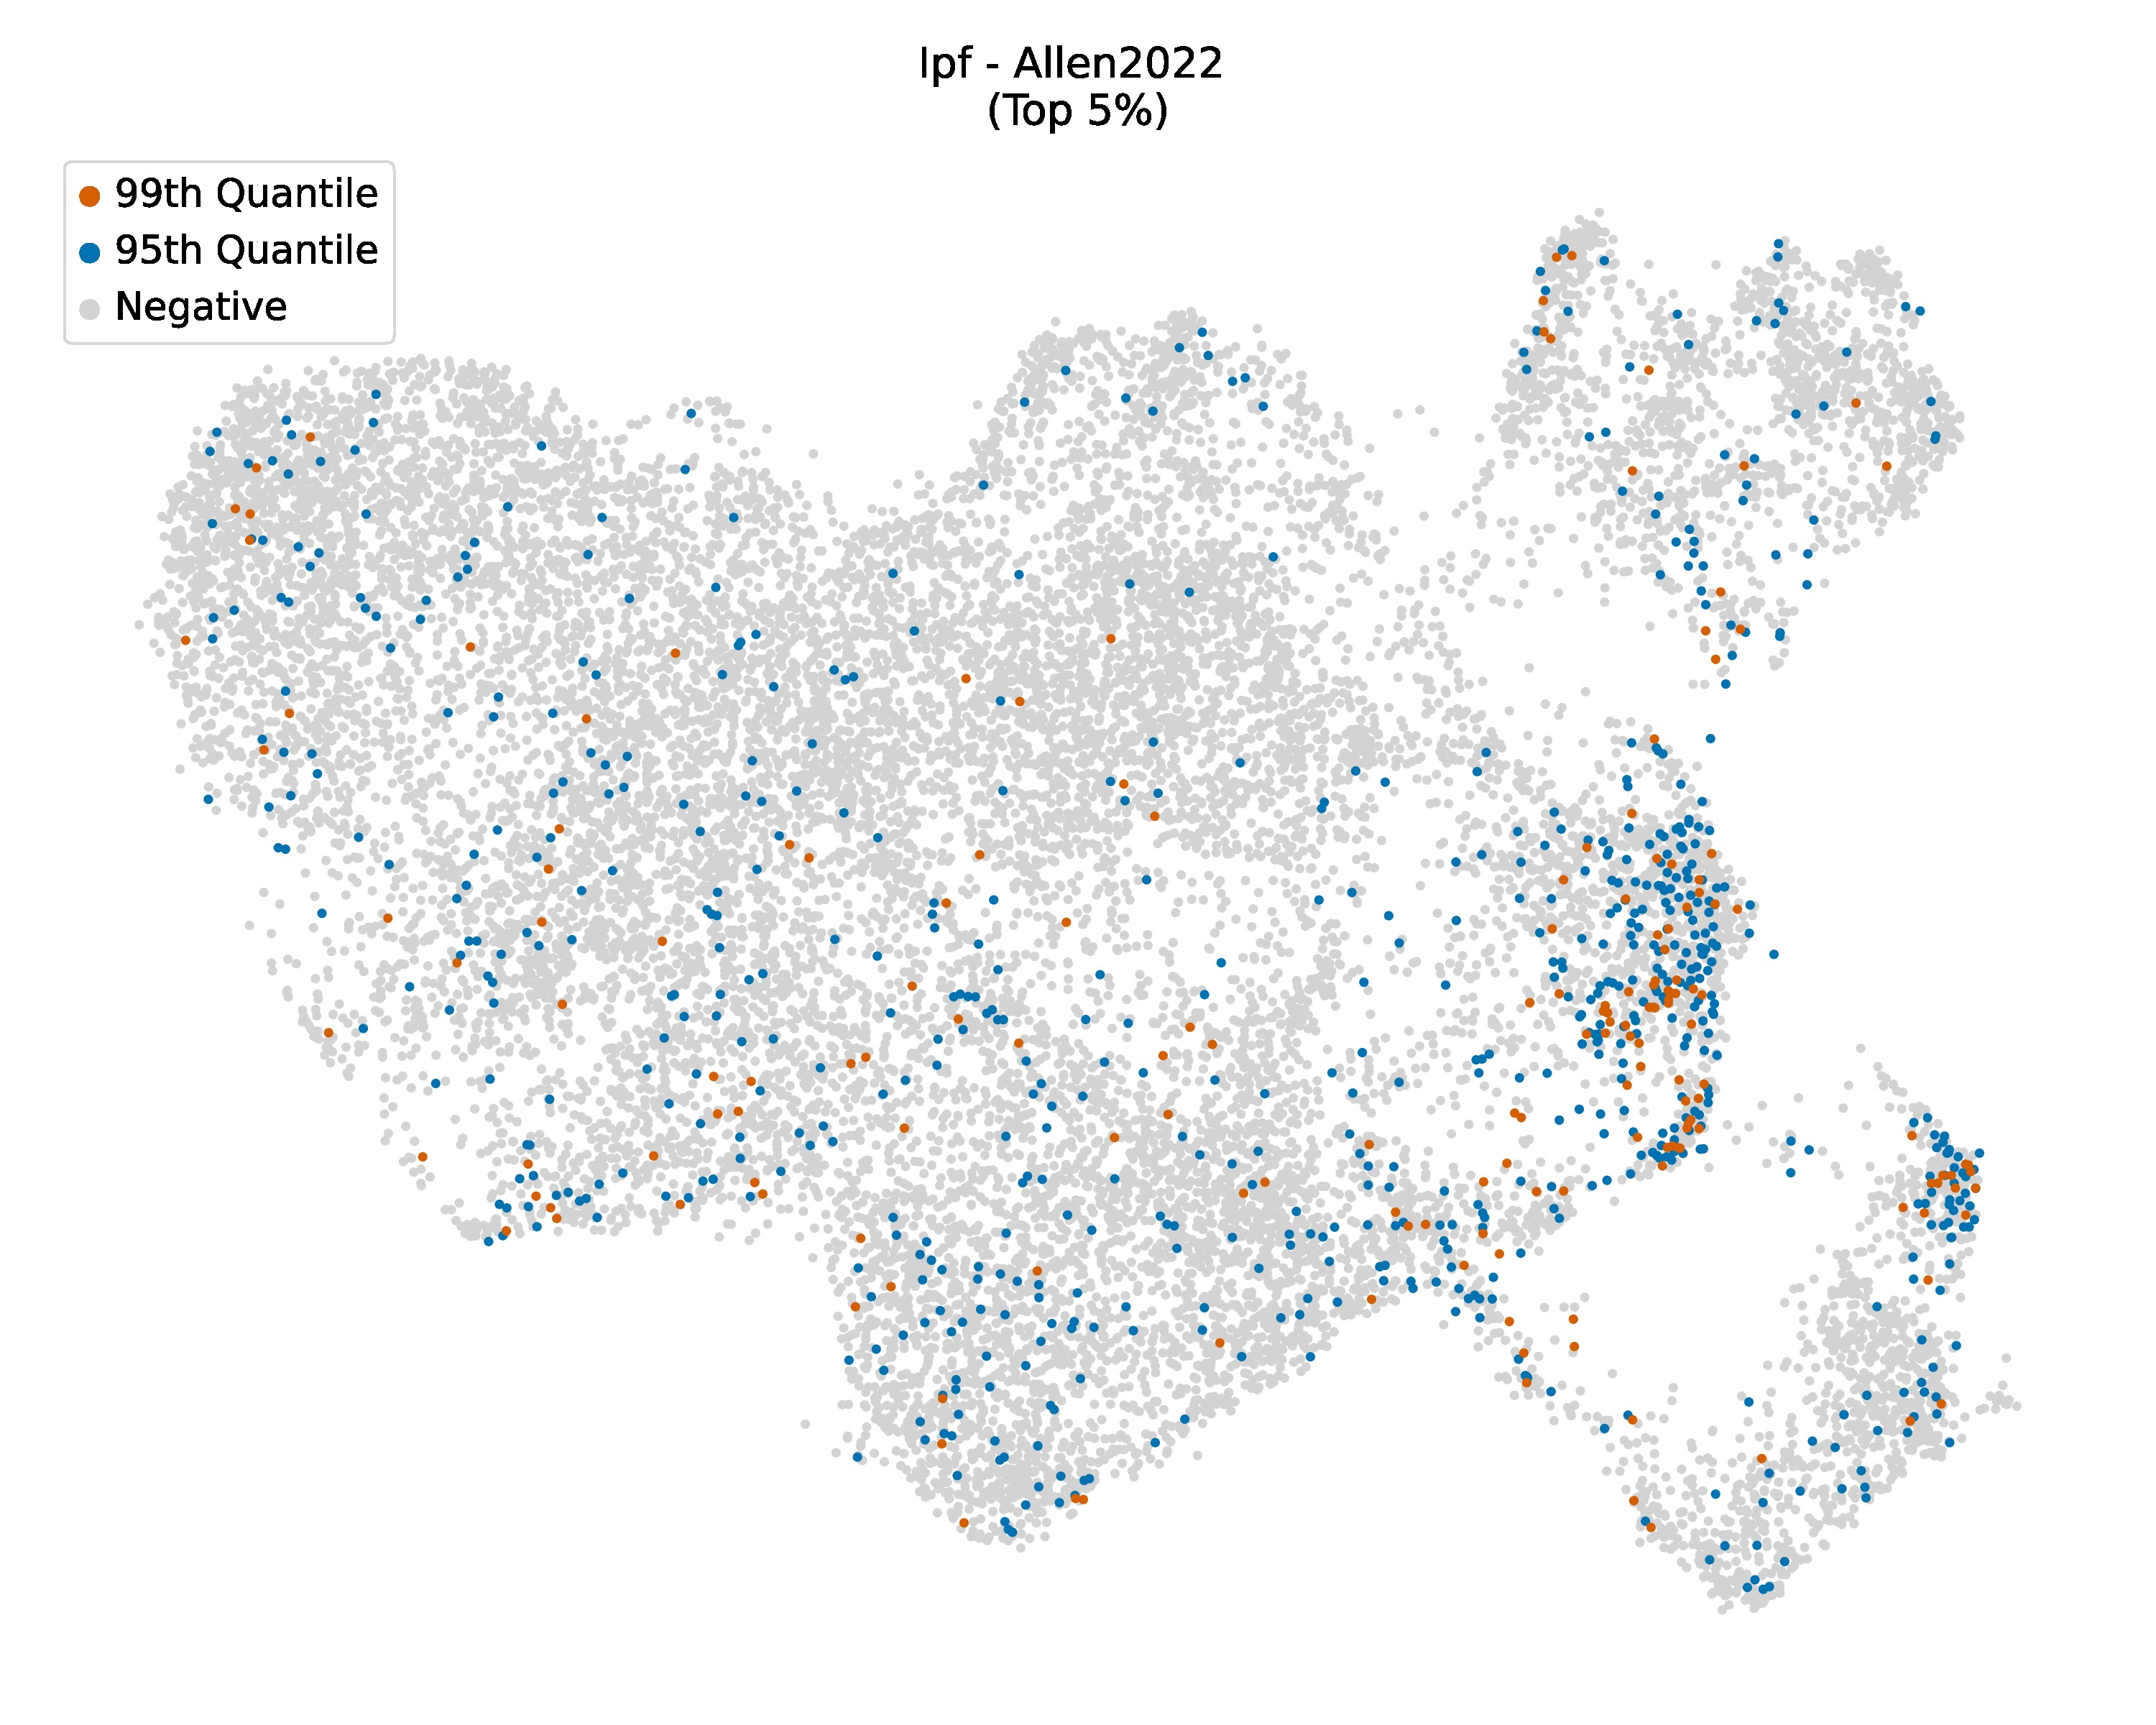

In [ ]:
trait = 'ipf_allen2022'

celltypes = ['Alveolar macrophage', 'Monocyte-like macrophage', 'Proliferating alveolar macrophage', 'Interstitial-like macrophage']
data = data[data.obs['Cell_Subtype'].isin(celltypes)]

# Initialize the subtype column
data.obs['myeloid_subtype'] = data.obs['Cell_Subtype']

# Convert mdm_clusters to integer
data.obs['mdm_clusters'] = pd.to_numeric(data.obs['mdm_clusters'], errors='coerce').dropna().astype(int)

# Assign Cell_Sub_subtype based on mdm_clusters values
data.obs['myeloid_subtype'] = data.obs['mdm_clusters'].map({
    0: 'MLM_0',
    1: 'MLM_1',
    2: 'IL1B+ Macrophage',
    3: 'CXCL10+ Macrophage',
    4: 'CCL2+ Macrophage',
    5: 'SPP1+ Macrophage'
}).fillna(data.obs['myeloid_subtype'])

# Define custom colors for specific myeloid_subtype to match trajectory
custom_colors = {
    'MLM_0': '#a6cee4',
    'MLM_1': '#2178b3',
    'IL1B+ Macrophage': '#b2df8a',
    'CXCL10+ Macrophage': '#32a02d',
    'CCL2+ Macrophage': '#fb9b99',
    'SPP1+ Macrophage': '#0ea8e8'
}

# Assign the custom colors to the data.uns
data = data[data.obs['myeloid_subtype'].notna()]
data.obs['myeloid_subtype'] = data.obs['myeloid_subtype'].astype('category')

# Top 5% for the selected trait
threshold_95 = data.obs[trait].quantile(0.95)
threshold_99 = data.obs[trait].quantile(0.99)
data.obs[f'{trait}_binary'] = data.obs[trait].apply(
    lambda x: 'Top1' if x > threshold_99 else ('Top5' if x > threshold_95 else 'Negative')
)

# Sort the data so that Positive points are plotted on top
palette = {'Top1': '#d55e00', 'Top5': '#0072b2', 'Negative': 'lightgray'}

# Sort the data so that Top1 points are plotted on top, then Top5, then Negative
data_sorted = data[data.obs[f'{trait}_binary'] == 'Negative'].concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top5']
).concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top1']
)

# Plot the UMAP with the binary classification
sc.pl.umap(data_sorted, color=f'{trait}_binary', palette=palette, save=False, frameon=False, size=40, title=f'{trait.replace("_", " - ").title()} \n(Top 5%)')

# Modify the legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['99th Quantile' if label == 'Top1' else '95th Quantile' if label == 'Top5' else 'Negative' for label in labels]
order = [new_labels.index('99th Quantile'), new_labels.index('95th Quantile'), new_labels.index('Negative')]
plt.legend([handles[idx] for idx in order], [new_labels[idx] for idx in order], loc='best')

plt.tight_layout()